In [701]:
import os

import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.model_selection import train_test_split
import tensorflow as tf

import pydot
import graphviz

from tensorflow.keras.utils import plot_model

from src.model.cmaqnet_cond_unet import build_model


In [702]:
# define constants
'''
model_path:str = ...
epochs:int = ...
batch_size:int = ...
test_split:float = ...
random_seed:int = ...
'''
model_path = '/home/user/workdir/main/src/model/small_1/final_model'  # 모델 저장 경로
epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.2  # 테스트 데이터 비율 (20%)           
random_seed = 42  # 랜덤 시드

In [703]:
# set model param. & show structure
'''
build_model(): cmaqnet_cond_unet.py 파일에 정의한 메소드임
    # ctrl_dim:     (int),          컨트롤 매트릭스 크기, 17개 지역과 5개의 전구체 활동을 포함한 차원 설정 (17*5)
    # cond_dim:     (Sequence[int]),모델이 처리할 조건 입력의 크기, 시간과 경계 조건에 대한 차원 리스트 [1, 1]
    # emb_dims:     (Sequence[int]),임베딩 레이어의 크기, [128, 128]인 경우 두 개의 임베딩 레이어가 각각 128 크기로 변환
    # emb_type:     (Sequence[str]),임베딩 레이어의 유형, time 또는 normal 중 선택하여 입력 데이터를 처리하는 방식을 결정 (시간 특화 임베딩, 일반 임베딩)
    # out_channel:  (int),          target value의 크기, 단일 출력값(PM2.5 농도)을 생성
    # hidden_size:  (Sequence[int]),초기 히든 레이어의 출력 크기, [128, 96]인 경우 초기 레이어 출력 크기 128x96
    # hidden_depth: (int),          U-Net 모델의 깊이, 4인 경우 인코더 4개와 디코더 3개 블록을 생성
    # kernel_size:  (int),          커널(필터)의 크기, 3인 경우 3x3 커널을 사용하여 이미지 또는 맵과 같은 공간 정보 처리 수준 조정
    # activation:   (str),          활성화 함수 유형, silu인 경우 Sigmoid Linear Unit을 적용
    # dropout:      (float),        드랍아웃 비율 정의, 0.0은 드랍아웃 사용하지 않음을 의미, 0.5는 50% 드랍아웃 적용
    # use_abs:      (bool),         출력값에 절대값 변환 여부, True라면 출력값이 모두 양수 변환
'''

# build model, Conditional U-Net의 모델 파라미터 설정
model = build_model(
    ctrl_dim=17*5,                  # 모델 입력, 17 지역(시, 도)과 5개 전구물질 배출량의 결합
    cond_dim=[1, 1],                # timestep과 boundary 조건 입력에 해당하는 속성 크기
    emb_dims=[64, 64],            # 임베딩 레이어의 데이터 차원
    emb_type=['time', 'normal'],    # 임베딩 유형
    out_channel=1,                  # target value의 크기
    hidden_size=[64, 96],          # 히든 레이어 출력 크기
    hidden_depth=3,                 # 인코더 및 디코더 레이어 등 히든 레이어 개수
    in_filters=5,                  # 초기 필터의 개수
    kernel_size=3,                  # 컨볼루션 연산에 사용하는 커널(필터) 사이즈
    activation='silu',              # 활성화 함수 유형 (Sigmoid ReLU)
    dropout=0.0,                    # 드롭아웃 수치
    use_abs=True)                   # 모델 출력의 절대값 유/무

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError(),)
# model.summary()
# plot_model(model, to_file='/home/user/workdir/main/model_structure.png', show_shapes=True, show_layer_names=True)

In [704]:
# define callback
'''
# scheduler(): epoch에 따라 학습률 조정.
#              학습 초기에는 높은 학습률(1e-3)로 빠르게 학습을 진행하고, 
#              후반부에는 낮은 학습률(1e-4)로 미세하게 조정하여 모델 성능을 최적화
'''
def scheduler(epoch, lr): 
    if epoch < 500: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

'''
# callback_ckpt: 학습 중 특정 조건(여기선 val_loss)을 기준으로 가장 성능이 좋은 모델을 저장
#                최적 모델을 복구하거나 재사용 가능하도록 함.

filepath: 모델을 저장할 경로를 지정.
monitor: val_loss(validation loss)를 모니터링하여 모델 성능을 평가.
save_best_only: True로 설정 시, 이전에 저장된 모델보다 val_loss가 개선된 경우에만 저장.
save_weights_only: False로 설정되어 있으므로 모델 전체(구조 및 가중치)를 저장.
mode: min은 모니터링 값(val_loss)이 최소값일 때 모델을 저장하도록 설정.
save_freq: epoch마다 체크포인트를 저장.
'''
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/small_1/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True, # 이전에 저장된 모델보다 val_loss가 개선된 경우에만 저장
    save_weights_only=False, # save_weights_only: False로 설정되어 있으므로 모델 전체(구조 및 가중치)를 저장합니다.
    mode='min',
    save_freq='epoch')

In [705]:
# load data
emis_ctrl_2019_05 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
print(emis_ctrl_2019_05.isnull().sum())
emis_ctrl_2019_05
# 모든 속성은 null값 없이 채워져있으며, 85개의 속성이 존재

A_NOX_ALL     0
A_SO2_ALL     0
A_VOC_ALL     0
A_NH3_ALL     0
A_PM25_ALL    0
             ..
Q_NOX_ALL     0
Q_SO2_ALL     0
Q_VOC_ALL     0
Q_NH3_ALL     0
Q_PM25_ALL    0
Length: 85, dtype: int64


,A_NOX_ALL,A_SO2_ALL,A_VOC_ALL,A_NH3_ALL,A_PM25_ALL,B_NOX_ALL,B_SO2_ALL,B_VOC_ALL,B_NH3_ALL,B_PM25_ALL,...,P_NOX_ALL,P_SO2_ALL,P_VOC_ALL,P_NH3_ALL,P_PM25_ALL,Q_NOX_ALL,Q_SO2_ALL,Q_VOC_ALL,Q_NH3_ALL,Q_PM25_ALL
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.863536,0.700099,1.241056,0.833703,0.812254,0.869754,0.796407,1.006564,0.962918,0.803118,...,0.870206,0.941031,1.121575,0.902626,0.901955,0.657383,1.139638,1.010165,1.315283,0.591438
3,0.742006,0.983985,0.646946,0.986340,0.956668,1.192631,0.832971,1.003773,0.780494,1.093660,...,1.278780,1.388193,1.284151,1.433524,1.372564,1.120913,0.763423,0.824734,1.290492,1.083136
4,1.242453,0.920476,1.263960,0.903860,1.061871,0.955693,1.146790,0.973506,0.906026,1.028232,...,0.993028,1.011176,1.163494,1.079287,1.086030,1.145995,1.079256,1.265949,0.777755,1.212820
5,0.814413,1.074629,0.735800,0.644385,0.682861,1.089342,0.986736,1.144006,1.188025,1.196274,...,1.094224,0.945197,0.868594,0.953091,1.067506,1.196717,1.317486,0.776720,1.122029,1.126078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.637726,0.623853,1.277424,1.161813,0.999322,1.338111,1.126068,0.680149,0.718203,1.227260,...,0.898629,1.043560,1.078804,1.119066,0.995012,1.270025,1.163085,0.775742,0.922857,1.157404
116,0.964623,0.645136,0.669842,1.231076,1.175551,0.848685,0.920326,0.912572,1.086990,0.827799,...,0.928756,0.698272,0.873848,0.698095,0.824039,1.115707,1.233914,1.026594,0.664581,1.191756
117,0.878997,0.964736,1.100528,1.000417,0.917413,0.616271,0.832265,0.970286,0.975696,0.753872,...,1.132273,0.952019,0.881093,0.863391,1.007772,1.264429,0.935599,1.006009,1.170412,1.044425
118,0.894946,1.035694,0.816513,0.883055,0.879394,0.915738,0.882485,0.947299,1.115599,0.836046,...,0.975411,1.017024,1.113508,0.992845,0.975551,1.253173,1.295791,1.164553,1.272193,1.253177


In [706]:
emis_ctrl_2019_05['Timestep'] = 0.0
emis_ctrl_2019_05['Boundary'] = 0.5
emis_ctrl_2019_05.head()
# Timestep과 Boundary 열이 생김

,A_NOX_ALL,A_SO2_ALL,A_VOC_ALL,A_NH3_ALL,A_PM25_ALL,B_NOX_ALL,B_SO2_ALL,B_VOC_ALL,B_NH3_ALL,B_PM25_ALL,...,P_VOC_ALL,P_NH3_ALL,P_PM25_ALL,Q_NOX_ALL,Q_SO2_ALL,Q_VOC_ALL,Q_NH3_ALL,Q_PM25_ALL,Timestep,Boundary
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.5
2,0.863536,0.700099,1.241056,0.833703,0.812254,0.869754,0.796407,1.006564,0.962918,0.803118,...,1.121575,0.902626,0.901955,0.657383,1.139638,1.010165,1.315283,0.591438,0.0,0.5
3,0.742006,0.983985,0.646946,0.986340,0.956668,1.192631,0.832971,1.003773,0.780494,1.093660,...,1.284151,1.433524,1.372564,1.120913,0.763423,0.824734,1.290492,1.083136,0.0,0.5
4,1.242453,0.920476,1.263960,0.903860,1.061871,0.955693,1.146790,0.973506,0.906026,1.028232,...,1.163494,1.079287,1.086030,1.145995,1.079256,1.265949,0.777755,1.212820,0.0,0.5
5,0.814413,1.074629,0.735800,0.644385,0.682861,1.089342,0.986736,1.144006,1.188025,1.196274,...,0.868594,0.953091,1.067506,1.196717,1.317486,0.776720,1.122029,1.126078,0.0,0.5


In [707]:
# emis_ctrl_2019_02 = emis_ctrl_2019_05.copy()
# emis_ctrl_2019_02['Boundary'] = 1.0
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0 # 경계 조건의 값이 1인 새로운 시나리오 생성
emis_ctrl_2019_10.head()

,A_NOX_ALL,A_SO2_ALL,A_VOC_ALL,A_NH3_ALL,A_PM25_ALL,B_NOX_ALL,B_SO2_ALL,B_VOC_ALL,B_NH3_ALL,B_PM25_ALL,...,P_VOC_ALL,P_NH3_ALL,P_PM25_ALL,Q_NOX_ALL,Q_SO2_ALL,Q_VOC_ALL,Q_NH3_ALL,Q_PM25_ALL,Timestep,Boundary
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0
2,0.863536,0.700099,1.241056,0.833703,0.812254,0.869754,0.796407,1.006564,0.962918,0.803118,...,1.121575,0.902626,0.901955,0.657383,1.139638,1.010165,1.315283,0.591438,0.0,1.0
3,0.742006,0.983985,0.646946,0.986340,0.956668,1.192631,0.832971,1.003773,0.780494,1.093660,...,1.284151,1.433524,1.372564,1.120913,0.763423,0.824734,1.290492,1.083136,0.0,1.0
4,1.242453,0.920476,1.263960,0.903860,1.061871,0.955693,1.146790,0.973506,0.906026,1.028232,...,1.163494,1.079287,1.086030,1.145995,1.079256,1.265949,0.777755,1.212820,0.0,1.0
5,0.814413,1.074629,0.735800,0.644385,0.682861,1.089342,0.986736,1.144006,1.188025,1.196274,...,0.868594,0.953091,1.067506,1.196717,1.317486,0.776720,1.122029,1.126078,0.0,1.0


In [708]:
ctrl_data = pd.concat([
    # emis_ctrl_2019_02,
    emis_ctrl_2019_05,
    emis_ctrl_2019_10
], axis=0, )
'''
axis=0 -> 행을 기준으로 데이터 병합
'''
ctrl_data.to_csv('emis_ctrl_data_two_scenario.csv')
ctrl_data

,A_NOX_ALL,A_SO2_ALL,A_VOC_ALL,A_NH3_ALL,A_PM25_ALL,B_NOX_ALL,B_SO2_ALL,B_VOC_ALL,B_NH3_ALL,B_PM25_ALL,...,P_VOC_ALL,P_NH3_ALL,P_PM25_ALL,Q_NOX_ALL,Q_SO2_ALL,Q_VOC_ALL,Q_NH3_ALL,Q_PM25_ALL,Timestep,Boundary
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.5
2,0.863536,0.700099,1.241056,0.833703,0.812254,0.869754,0.796407,1.006564,0.962918,0.803118,...,1.121575,0.902626,0.901955,0.657383,1.139638,1.010165,1.315283,0.591438,0.0,0.5
3,0.742006,0.983985,0.646946,0.986340,0.956668,1.192631,0.832971,1.003773,0.780494,1.093660,...,1.284151,1.433524,1.372564,1.120913,0.763423,0.824734,1.290492,1.083136,0.0,0.5
4,1.242453,0.920476,1.263960,0.903860,1.061871,0.955693,1.146790,0.973506,0.906026,1.028232,...,1.163494,1.079287,1.086030,1.145995,1.079256,1.265949,0.777755,1.212820,0.0,0.5
5,0.814413,1.074629,0.735800,0.644385,0.682861,1.089342,0.986736,1.144006,1.188025,1.196274,...,0.868594,0.953091,1.067506,1.196717,1.317486,0.776720,1.122029,1.126078,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.637726,0.623853,1.277424,1.161813,0.999322,1.338111,1.126068,0.680149,0.718203,1.227260,...,1.078804,1.119066,0.995012,1.270025,1.163085,0.775742,0.922857,1.157404,0.0,1.0
116,0.964623,0.645136,0.669842,1.231076,1.175551,0.848685,0.920326,0.912572,1.086990,0.827799,...,0.873848,0.698095,0.824039,1.115707,1.233914,1.026594,0.664581,1.191756,0.0,1.0
117,0.878997,0.964736,1.100528,1.000417,0.917413,0.616271,0.832265,0.970286,0.975696,0.753872,...,0.881093,0.863391,1.007772,1.264429,0.935599,1.006009,1.170412,1.044425,0.0,1.0
118,0.894946,1.035694,0.816513,0.883055,0.879394,0.915738,0.882485,0.947299,1.115599,0.836046,...,1.113508,0.992845,0.975551,1.253173,1.295791,1.164553,1.272193,1.253177,0.0,1.0


In [709]:
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, time_data, boundary_data = ctrl_data[:, :85], ctrl_data[:, 85], ctrl_data[:, 86]
'''
ctrl_data[A, B]=> A: row에 해당, B: column에 해당
emis_data: 대한민국 지역 별 5개 전구체 활동 데이터 (17*5 -> 85)
time_data: Timestep 속성 값
boundary_data: 경계 조건 속성 값
'''

'\nctrl_data[A, B]=> A: row에 해당, B: column에 해당\nemis_data: 대한민국 지역 별 5개 전구체 활동 데이터 (17*5 -> 85)\ntime_data: Timestep 속성 값\nboundary_data: 경계 조건 속성 값\n'

In [710]:
print(emis_data.shape)
print(time_data.shape)
print(boundary_data.shape)

(238, 85)
(238,)
(238,)


In [711]:
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '0.50', f'ACONC.{i}')) # total length: 119
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}')) # total length: 119
# /home/user/workdir/main/datasets/concentration/2019/0.50/ACONC.1

print("length of conc_path:", len(conc_path))
conc_path[0]

length of conc_path: 238


'/home/user/workdir/main/datasets/concentration/2019/0.50/ACONC.1'

In [712]:
'''
netCDF 로드 (label 값)
'''
conc_data = []
for path in conc_path: # total length: 238
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1) # (238, 82, 67, 1)

In [713]:
'''
'/home/user/workdir/main/datasets/concentration/2019/0.50/ACONC.1' -> netCDF 파일

(파일 내 변수들)
TFLAG           O3              CO              NO              NO2             
NOX             SO2             SULF            NH3             PM2_5           
PM10            Isoprene        Nitrate         Sulfate         Ammonium        
TOLSOA          XYLSOA          BNZSOA          EC              SOA             
Ethane          Toluene         Xylene          SV_Benzene      Benzene         
All_Benzene  
'''

"\n'/home/user/workdir/main/datasets/concentration/2019/0.50/ACONC.1' -> netCDF 파일\n\n(파일 내 변수들)\nTFLAG           O3              CO              NO              NO2             \nNOX             SO2             SULF            NH3             PM2_5           \nPM10            Isoprene        Nitrate         Sulfate         Ammonium        \nTOLSOA          XYLSOA          BNZSOA          EC              SOA             \nEthane          Toluene         Xylene          SV_Benzene      Benzene         \nAll_Benzene  \n"

(1, 1, 82, 67)
(82, 67)
4.552888


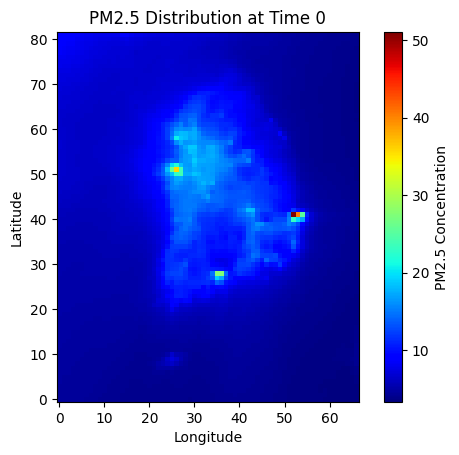

In [714]:
pm25_data = []
with nc.Dataset('/home/user/workdir/main/datasets/concentration/2019/0.50/ACONC.1') as f:
    data = f.variables['PM2_5'][:]
    print(data.shape)
    pm25_data = data.squeeze()
    print(pm25_data.shape)
    print(pm25_data.data[0][0])

'''
netCDF 파일 이미지화
'''
import matplotlib.pyplot as plt

# plt.imshow(pm25_data.data[:][:], origin="lower")
plt.imshow(pm25_data, origin="lower", cmap='jet')
plt.colorbar(label="PM2.5 Concentration")
plt.title("PM2.5 Distribution at Time 0")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [715]:
X_emis_train, X_emis_test, X_time_train, X_time_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, time_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

In [716]:
print(X_emis_train)
print('X_emis_train.shpae:',X_emis_train.shape)
print(X_emis_test)
print('X_emis_train:', X_emis_test.shape)

[[0.63324643 0.84864682 0.68505922 ... 0.60059919 0.53532226 0.59330644]
 [0.64309813 0.69945141 0.66204405 ... 0.82895246 0.89217326 0.97386404]
 [1.1882027  0.97302038 0.6881254  ... 1.22228068 0.6172111  0.95148937]
 ...
 [1.05693662 1.47606696 1.10106727 ... 0.84505017 0.62748709 1.0859534 ]
 [1.13823103 0.81917009 1.38526701 ... 1.06798793 1.35681241 0.88698202]
 [0.90482245 0.84816607 0.99409973 ... 0.83798584 0.59864761 1.1159378 ]]
X_emis_train.shpae: (190, 85)
[[0.96462278 0.64513621 0.66984151 ... 1.02659371 0.66458063 1.19175598]
 [0.88757615 1.44602701 1.00186434 ... 0.92317601 1.30067404 0.75789459]
 [1.20370947 1.40771856 0.86716117 ... 0.75915328 1.43986217 1.00480714]
 ...
 [1.15304118 1.20328049 0.99490289 ... 1.20897927 1.39916352 1.03948622]
 [0.97456976 0.75482525 0.74853546 ... 0.9247598  0.72403292 1.11484321]
 [0.92915485 0.64180575 1.08527994 ... 1.07499926 1.44412587 0.95372204]]
X_emis_train: (48, 85)


In [717]:
print(X_time_train)
print('X_time_train.shpae:', X_time_train.shape)
print(X_time_test)
print('X_time_train.shpae:', X_time_test.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_time_train.shpae: (190,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_time_train.shpae: (48,)


In [718]:
print(X_boundary_train)
print('X_boundary_train.shpae:', X_boundary_train.shape)
print(X_boundary_test)
print('X_boundary_test.shpae:', X_boundary_test.shape)

[1.  1.  1.  0.5 1.  0.5 1.  0.5 1.  1.  0.5 1.  1.  1.  0.5 1.  0.5 1.
 0.5 0.5 1.  1.  0.5 0.5 0.5 1.  1.  0.5 0.5 1.  1.  0.5 0.5 1.  1.  1.
 0.5 0.5 0.5 0.5 0.5 0.5 1.  1.  0.5 1.  1.  0.5 0.5 0.5 1.  0.5 1.  0.5
 1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.5 1.  1.  1.  0.5 0.5 1.  1.  0.5 0.5
 1.  0.5 0.5 0.5 1.  1.  0.5 0.5 1.  0.5 1.  0.5 1.  0.5 1.  0.5 1.  1.
 1.  1.  0.5 1.  0.5 0.5 1.  0.5 1.  0.5 1.  1.  0.5 0.5 1.  0.5 0.5 1.
 0.5 1.  1.  0.5 0.5 0.5 1.  1.  1.  1.  0.5 1.  0.5 0.5 0.5 1.  0.5 0.5
 0.5 1.  1.  0.5 0.5 0.5 0.5 1.  1.  0.5 1.  0.5 1.  1.  1.  1.  0.5 0.5
 0.5 0.5 1.  1.  1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.
 1.  1.  0.5 1.  1.  0.5 0.5 1.  1.  1.  0.5 0.5 0.5 0.5 1.  0.5 1.  1.
 1.  1.  0.5 1.  0.5 0.5 0.5 0.5 1.  0.5]
X_boundary_train.shpae: (190,)
[0.5 0.5 1.  1.  0.5 1.  0.5 1.  0.5 1.  1.  1.  0.5 1.  0.5 0.5 0.5 1.
 0.5 0.5 1.  1.  1.  1.  0.5 1.  1.  0.5 0.5 0.5 1.  1.  1.  0.5 0.5 0.5
 1.  1.  0.5 0.5 0.5 0.5 0.5 0.5 1.  1.  0.5 1. ]
X_bounda

In [719]:
print(y_train)
print('y_train.shpae:', y_train.shape) # y_train.shpae: (190, 82, 67, 1)
print(y_test)
print('y_test.shpae:', y_test.shape) # y_test.shpae: (48, 82, 67, 1)

[[[[ 9.298476 ]
   [ 9.215129 ]
   [ 8.975108 ]
   ...
   [ 4.979867 ]
   [ 4.9117656]
   [ 4.980379 ]]

  [[ 9.338612 ]
   [ 9.254149 ]
   [ 9.08935  ]
   ...
   [ 4.9843225]
   [ 4.938552 ]
   [ 4.9001713]]

  [[ 9.487179 ]
   [ 9.350584 ]
   [ 9.193748 ]
   ...
   [ 5.012111 ]
   [ 5.003289 ]
   [ 5.0721145]]

  ...

  [[18.30496  ]
   [18.01799  ]
   [17.685978 ]
   ...
   [ 8.814559 ]
   [ 8.770229 ]
   [ 8.753708 ]]

  [[18.400955 ]
   [18.122595 ]
   [17.738739 ]
   ...
   [ 8.800408 ]
   [ 8.750205 ]
   [ 8.712339 ]]

  [[18.514542 ]
   [18.30055  ]
   [17.78931  ]
   ...
   [ 8.794484 ]
   [ 8.736435 ]
   [ 8.707952 ]]]


 [[[ 9.277998 ]
   [ 9.192881 ]
   [ 8.952874 ]
   ...
   [ 4.9354186]
   [ 4.874018 ]
   [ 4.9501395]]

  [[ 9.317515 ]
   [ 9.231094 ]
   [ 9.066225 ]
   ...
   [ 4.940626 ]
   [ 4.901623 ]
   [ 4.8696914]]

  [[ 9.463973 ]
   [ 9.327366 ]
   [ 9.170683 ]
   ...
   [ 4.9672594]
   [ 4.9653897]
   [ 5.040771 ]]

  ...

  [[18.291111 ]
   [18.006824 ]
   [17.

In [720]:
# train model
'''
history = model.fit(
    x=[X_emis_train, X_time_train, X_boundary_train],
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_time_test, X_boundary_test], y_test],
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)
''' 

'\nhistory = model.fit(\n    x=[X_emis_train, X_time_train, X_boundary_train],\n    y=y_train,\n    epochs=epochs,\n    batch_size=batch_size,\n    validation_data=[[X_emis_test, X_time_test, X_boundary_test], y_test],\n    callbacks=[callback_lr, callback_ckpt])\nmodel.save(model_path)\n'